<a href="https://colab.research.google.com/github/mylovepyd03/26-1-Lab-Intern/blob/main/CNN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 19.4 MB/s eta 0:00:00


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- test code에서 label을 주지 않고 사진만 넣어서 예측하게 해보기

# CNN

In [20]:
import os
from PIL import Image
import json

class TicTacToeCellDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels_paths = []

        # 1. 이미지 폴더에서 .jpg 파일만 가져오기
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)

            # 2. 파일 이름 규칙 수정: '06.jpg' -> '06_labels.json'
            file_number = os.path.splitext(image_file)[0] # '06' 추출
            label_filename = f"{file_number}_labels.json" # '06_labels.json' 생성
            label_path = os.path.join(label_dir, label_filename)

            # 3. 해당 라벨 파일이 진짜 있을 때만 리스트에 추가
            if os.path.exists(label_path):
                self.image_paths.append(image_path)
                self.labels_paths.append(label_path)

        print(f"✅ 매칭 성공: {len(self.image_paths)}개의 이미지와 라벨 짝을 찾았습니다!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.labels_paths[idx]

        image = Image.open(image_path).convert('RGB')

        with open(label_path, 'r') as f:
            label_data = json.load(f)

        # O, X, blank 매핑 (정수형 long 타입으로 변환)
        label_mapping = {'O': 0, 'X': 1, 'blank': 2}
        label_list = [label_mapping[label_data[f'cell_{i}']] for i in range(9)]
        label_tensor = torch.tensor(label_list, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class TicTacToeCNN(nn.Module):
    def __init__(self):
        super(TicTacToeCNN, self).__init__()
        '''
        hint: convoluation layer, batch normalization, dropout, fully connected 사용
        '''
        # 여기에 코드 작성해주세요
        #
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #rgb이미지3, 출력채널=32,필터크기3x3 ,패딩: 이미지크기유지
        self.bn1 = nn.BatchNorm2d(32) #여기서 채널은 특징의 개수를 의미한다ㅣ.
        #conv2는 conv1의 출력을 입력으로 받는다.
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        #채널 각각을 정규화: 학습을 안정적으로 만들기 위한 장치
         # Dropout:특정 패턴에만 과하게 의존하는 과적합을 막기위한것
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        #fully connected:
        self.fc1 = nn.Linear(128 * 4 * 4, 128) #8192개를 128로 줄이겟다 여기오류있음 4*4로 바꾸거나 입력을 64로해야함
        self.fc2 = nn.Linear(128, 27)
         # 여기에 코드 작성해주세요  # O, X, blank (3 classes)
         #입력이 64여야함

    def forward(self, x):
        # 여기에 코드 작성해주세요
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Conv Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Conv Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)


        return x

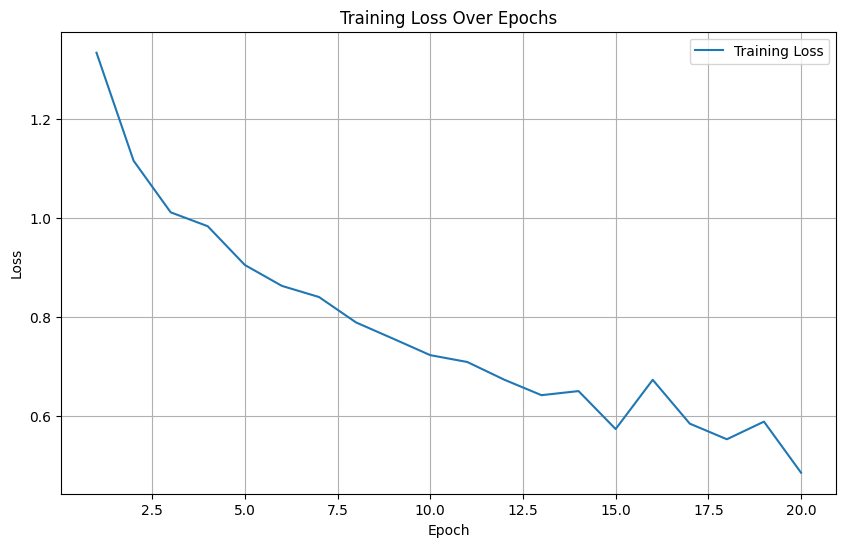

✅ 매칭 성공: 40개의 이미지와 라벨 짝을 찾았습니다!
Epoch [1/20], Loss: 1.2320
Epoch [2/20], Loss: 1.0547
Epoch [3/20], Loss: 0.9968
Epoch [4/20], Loss: 0.9869
Epoch [5/20], Loss: 0.9489
Epoch [6/20], Loss: 0.8691
Epoch [7/20], Loss: 0.8634
Epoch [8/20], Loss: 0.8636
Epoch [9/20], Loss: 0.8123
Epoch [10/20], Loss: 0.7550
Epoch [11/20], Loss: 0.7238
Epoch [12/20], Loss: 0.6415
Epoch [13/20], Loss: 0.6598
Epoch [14/20], Loss: 0.6105
Epoch [15/20], Loss: 0.5753
Epoch [16/20], Loss: 0.6371
Epoch [17/20], Loss: 0.5584
Epoch [18/20], Loss: 0.5195
Epoch [19/20], Loss: 0.5289
Epoch [20/20], Loss: 0.5449


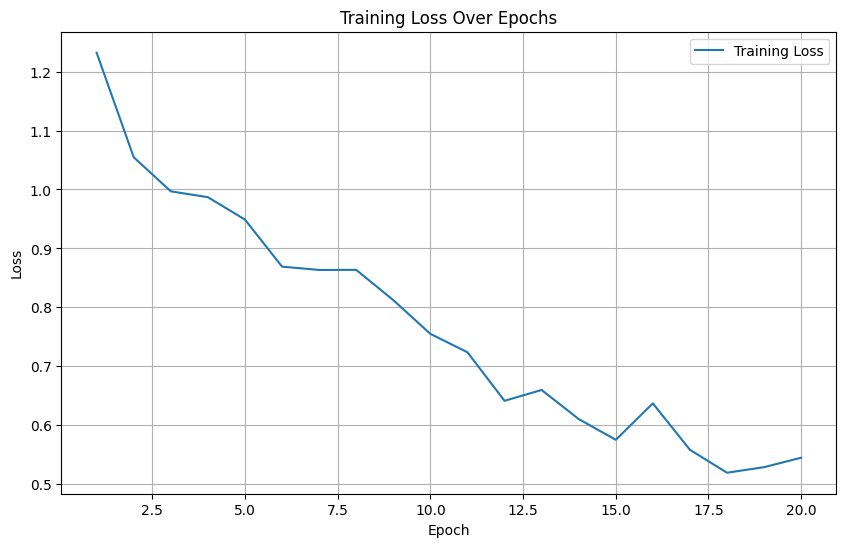

In [24]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# 그다음 아래 그래프 코드를 실행하면 됩니다.
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# 데이터셋 및 데이터로더
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
     #사이즈 표준화, 폴딩 3번이므로 입력 무조건 32 들어와야하고 위에ㅔ 8대신 4로 바꿈

dataset = TicTacToeCellDataset(image_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_black', label_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
#DataLoader: 데이터를 한꺼번에 다 넣으면 메모리가 터질 수 있으니, 8개씩(Batch) 잘라서 모델에게 전달하는 역할.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = TicTacToeCNN().to(device)
criterion = nn.CrossEntropyLoss() # 모델의 예측값과 실제 정답 사이의 오차를 계산 /다중클래스 분류용 손실함수, 가장큰값이 모델이 고른 클래스 (27개)
optimizer = optim.Adam(model.parameters(), lr=0.001)#학습률 얼마나 크게할지

# 학습 루프
epochs = 20 # 특별한 의미없이 10~30 사이)
loss_history = []

'''
hint: loss 그래프를 출력할 수 있도록 for loop가 돌아가기 전 loss_history=[] 만들기
      loss 출력값 확인해보는 것도 좋습니다.
'''
# 여기에 코드 작성해주세요
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        #데이터를 GPU로 이동

        optimizer.zero_grad() #기울기초기화 :이전루프의 계산값이 남아있지 않도록 비우기

        outputs = model(images)

        outputs = outputs.view(-1, 3)
        labels = labels.view(-1).long()
        loss = criterion(outputs, labels) #손실계산

        loss.backward()#역전파 (Backward): 어떤 가중치를 수정해야 오차가 줄어들지 미분 계산
        optimizer.step() #가중치 업데이트

        running_loss += loss.item() #오차기록
      #시각화 하기
    epoch_loss = running_loss / len(dataloader) #각 에포크마다 평균오차를 계산해 리스트에 저장하기.
    loss_history.append(epoch_loss) #(만들어둔 리스트에)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Validation ver.

✅ 매칭 성공: 3개의 데이터를 찾았습니다!
Epoch 1/20, Training Loss: 1.1820, Validation Loss: 1.1084
Epoch 2/20, Training Loss: 0.9232, Validation Loss: 1.0923
Epoch 3/20, Training Loss: 0.7043, Validation Loss: 1.0667
Epoch 4/20, Training Loss: 0.4187, Validation Loss: 1.0438
Epoch 5/20, Training Loss: 0.5614, Validation Loss: 1.0170
Epoch 6/20, Training Loss: 0.6885, Validation Loss: 0.9891
Epoch 7/20, Training Loss: 0.3175, Validation Loss: 0.9615
Epoch 8/20, Training Loss: 0.3468, Validation Loss: 0.9272
Epoch 9/20, Training Loss: 0.3375, Validation Loss: 0.9052
Epoch 10/20, Training Loss: 0.2843, Validation Loss: 0.8972
Epoch 11/20, Training Loss: 0.0726, Validation Loss: 0.9019
Epoch 12/20, Training Loss: 0.0859, Validation Loss: 0.9095
Epoch 13/20, Training Loss: 0.0377, Validation Loss: 0.9257
Epoch 14/20, Training Loss: 0.1858, Validation Loss: 0.9439
Epoch 15/20, Training Loss: 0.1767, Validation Loss: 0.9720
Epoch 16/20, Training Loss: 0.2992, Validation Loss: 0.9976
Epoch 17/20, Training Lo

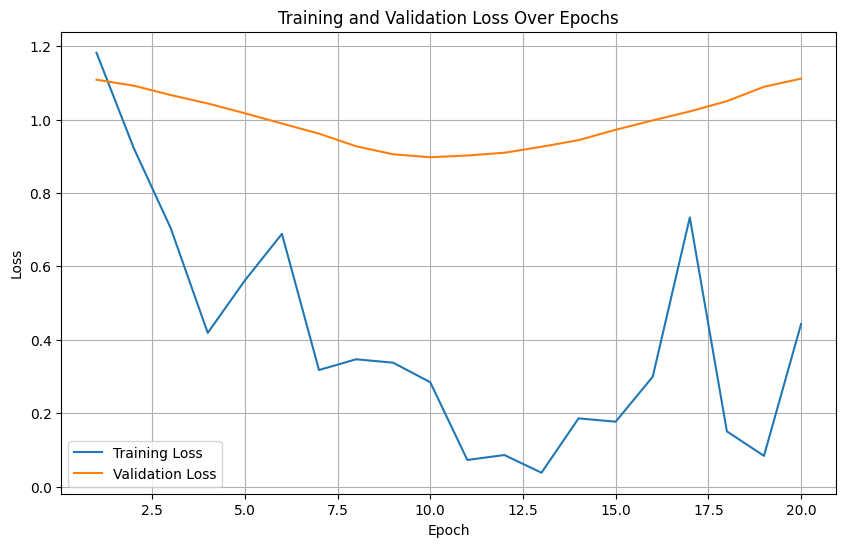

In [34]:
#검정할때는 모델을 고치면 안됨
#1. 기울기 계산할 필요가 없고, 가중치를 수정하지 않는다.
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset  # Subset 추가 필수!
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class TicTacToeCellDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels_paths = []

        # [수정된 부분] 폴더 안의 파일들을 리스트로 만듭니다. (pd.read_csv는 이제 필요 없어요!)
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

        for image_file in image_files:
            file_number = os.path.splitext(image_file)[0]
            label_filename = f"{file_number}_labels.json" # 파일명 규칙에 맞춰 생성
            label_path = os.path.join(label_dir, label_filename)

            if os.path.exists(label_path):
                self.image_paths.append(os.path.join(image_dir, image_file))
                self.labels_paths.append(label_path)

        print(f"✅ 매칭 성공: {len(self.image_paths)}개의 데이터를 찾았습니다!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 개별 이미지와 JSON 파일을 읽어옵니다.
        image = Image.open(self.image_paths[idx]).convert('RGB')
        with open(self.labels_paths[idx], 'r') as f:
            label_data = json.load(f)

        label_mapping = {'O': 0, 'X': 1, 'blank': 2}
        label_list = [label_mapping[label_data[f'cell_{i}']] for i in range(9)]
        label_tensor = torch.tensor(label_list, dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label_tensor

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
])


dataset = TicTacToeCellDataset(
    image_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_test',    # 이미지 폴더 경로
    label_dir='//content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels_test', # 정답(라벨) 파일 경로
    transform=transform
)

# train, test split
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset=Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TicTacToeCNN().to(device)  # 어제 정의한 모델 클래스
criterion = torch.nn.CrossEntropyLoss() # 분류 문제의 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 가중치 업데이트 도구

# 학습 루프
train_loss_history = []
val_loss_history = []
epochs = 20
# 1. train 단계
# 여기에 코드 작성해주세요
# [1. Train 단계] - 실력을 키우는 단계
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()  # 1. 기울기(연습장) 초기화
        prediction = model(x).view(-1, 3) # 27개 출력을 3개씩 9칸으로!
        loss = criterion(prediction, y.view(-1)) # 정답과 매칭
        loss.backward()        # 4. 역전파 (기울기/수정계획 계산)
        optimizer.step()       # 5. 가중치 업데이트 (진짜 수정)

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)


    # 2. Validation 단계
    model.eval()
    # 여기에 코드 작성해주세요
    epoch_val_loss = 0
    with torch.no_grad(): # 기울기 계산을 완전히 꺼서 가중치 보호 및 메모리 절약
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            prediction = model(x).view(-1, 3)
            loss = criterion(prediction, y.view(-1))
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    # Print training and validation losses
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [19]:
import os

img_dir = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_black'
lbl_dir = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels'

print("이미지 폴더 파일 5개:", os.listdir(img_dir)[:5])
print("라벨 폴더 파일 5개:", os.listdir(lbl_dir)[:5])

이미지 폴더 파일 5개: ['17.jpg', '06.jpg', '09.jpg', '07.jpg', '02.jpg']
라벨 폴더 파일 5개: ['IMG_0722_labels.json', '16_labels.json', 'IMG_0726_labels.json', 'IMG_0727_labels.json', 'IMG_0719_labels.json']


# Test
- 해당 코드를 돌렸을 때 80% 이상의 정확도 나오게 만들기

✅ 매칭 성공: 3개의 데이터를 찾았습니다!


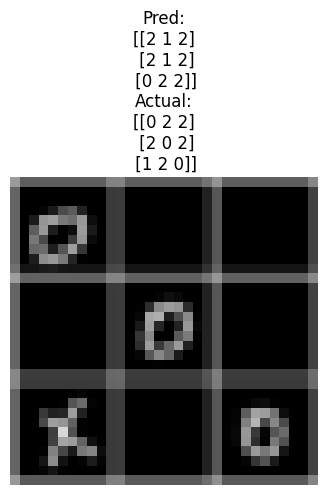

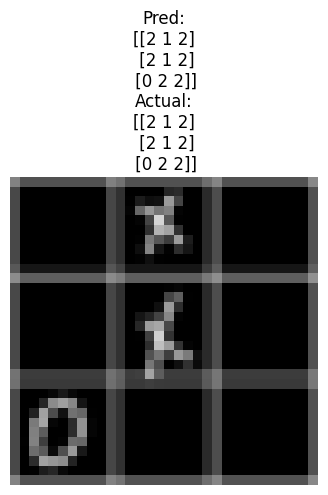

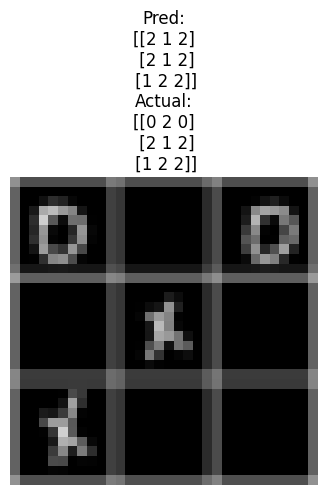

✅ 최종 테스트 정확도: 70.37%


In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터셋을 위한 변환 설정 (이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# 1. 경로 설정 (아까 성공했던 그 경로를 그대로 넣으세요!)
TEST_IMAGE_DIR = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_test'
TEST_LABEL_DIR = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels_test'

# 2. 데이터 로더
test_dataset = TicTacToeCellDataset(image_dir=TEST_IMAGE_DIR, label_dir=TEST_LABEL_DIR, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 루프
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device) # 정답: [batch, 9]

        # 모델 예측: 결과 [batch, 27]
        outputs = model(inputs)

        # [핵심 수정] 27개를 (9칸, 3클래스)로 쪼개기 -> [batch, 9, 3]
        outputs = outputs.view(-1, 9, 3)

        # 각 셀별로 가장 높은 확률의 클래스 선택 -> [batch, 9]
        predicted = torch.argmax(outputs, dim=2)

        # 정확도 계산
        total += labels.numel()
        correct += (predicted == labels).sum().item()

        # 시각화를 위해 모양 변경
        predicted_grid = predicted.view(-1, 3, 3)
        labels_grid = labels.view(-1, 3, 3)

        # 샘플 시각화 (첫 번째 배치만)
        for i in range(inputs.size(0)):
            plt.figure(figsize=(4, 4))
            # 이미지 원복 (Tensor -> Numpy)
            img = inputs[i].cpu().numpy().transpose(1, 2, 0)
            plt.imshow(img)
            plt.title(f"Pred:\n{predicted_grid[i].cpu().numpy()}\nActual:\n{labels_grid[i].cpu().numpy()}")
            plt.axis("off")
            plt.show()

# 최종 정확도 출력
accuracy = 100 * correct / total
print(f"✅ 최종 테스트 정확도: {accuracy:.2f}%")
